Customer Clustering
===================
Using PCA and DBSCAN to cluster customers based on their demographic and
behavioral data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
import optuna
from sklearn.pipeline import Pipeline
import joblib
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from datetime import datetime, timedelta
import humanize

import sys
sys.path.append('../lib')
from visualization_helpers import pareto

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set default font
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

sns.set(font=font_prop.get_name())
mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.weight"] = 'semibold'

bold = 'extra bold'

In [4]:
random_state = 42

## EDA

In [5]:
# Source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
original_df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [6]:
df = original_df.copy()

In [7]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [9]:
df.isna().sum().sum()

24

In [10]:
na = df.isna().sum()
na[na > 0]

Income    24
dtype: int64

Just a few NA values in the income column. We can fill them with the median.
or drop them entirely.

In [11]:
for col in df.select_dtypes(include='object'):
    print(f'{col}: {df[col].nunique()}')

Education: 5
Marital_Status: 8
Dt_Customer: 663


From the datasets documentation we know that `Dt_Customer` is the date when
the customer was registered. Let's convert it to a datetime object.

In [12]:
df['Dt_Customer'].head(10)

0    04-09-2012
1    08-03-2014
2    21-08-2013
3    10-02-2014
4    19-01-2014
5    09-09-2013
6    13-11-2012
7    08-05-2013
8    06-06-2013
9    13-03-2014
Name: Dt_Customer, dtype: object

The format is day-month-year.

In [13]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

In [14]:
for col in df.select_dtypes(include='object'):
    print(df[col].value_counts())
    print()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64



We could convert the `Education` column to an ordinal column.

In [15]:
df['EducationOrdinal'] = df['Education'].map({
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
    })

df.drop(columns=['Education'], inplace=True)

In [16]:
pd.DataFrame(df['EducationOrdinal'].value_counts().sort_index()).style.background_gradient()

,count
EducationOrdinal,
0,54
1,203
2,1127
3,370
4,486


In [17]:
df.drop(columns=['ID', 'Marital_Status'], inplace=True)

In [18]:
df.head(3).T

,0,1,2
Year_Birth,1957,1954,1965
Income,58138.0,46344.0,71613.0
Kidhome,0,1,0
Teenhome,0,1,0
Dt_Customer,2012-09-04 00:00:00,2014-03-08 00:00:00,2013-08-21 00:00:00
Recency,58,38,26
MntWines,635,11,426
MntFruits,88,1,49
MntMeatProducts,546,6,127
MntFishProducts,172,2,111


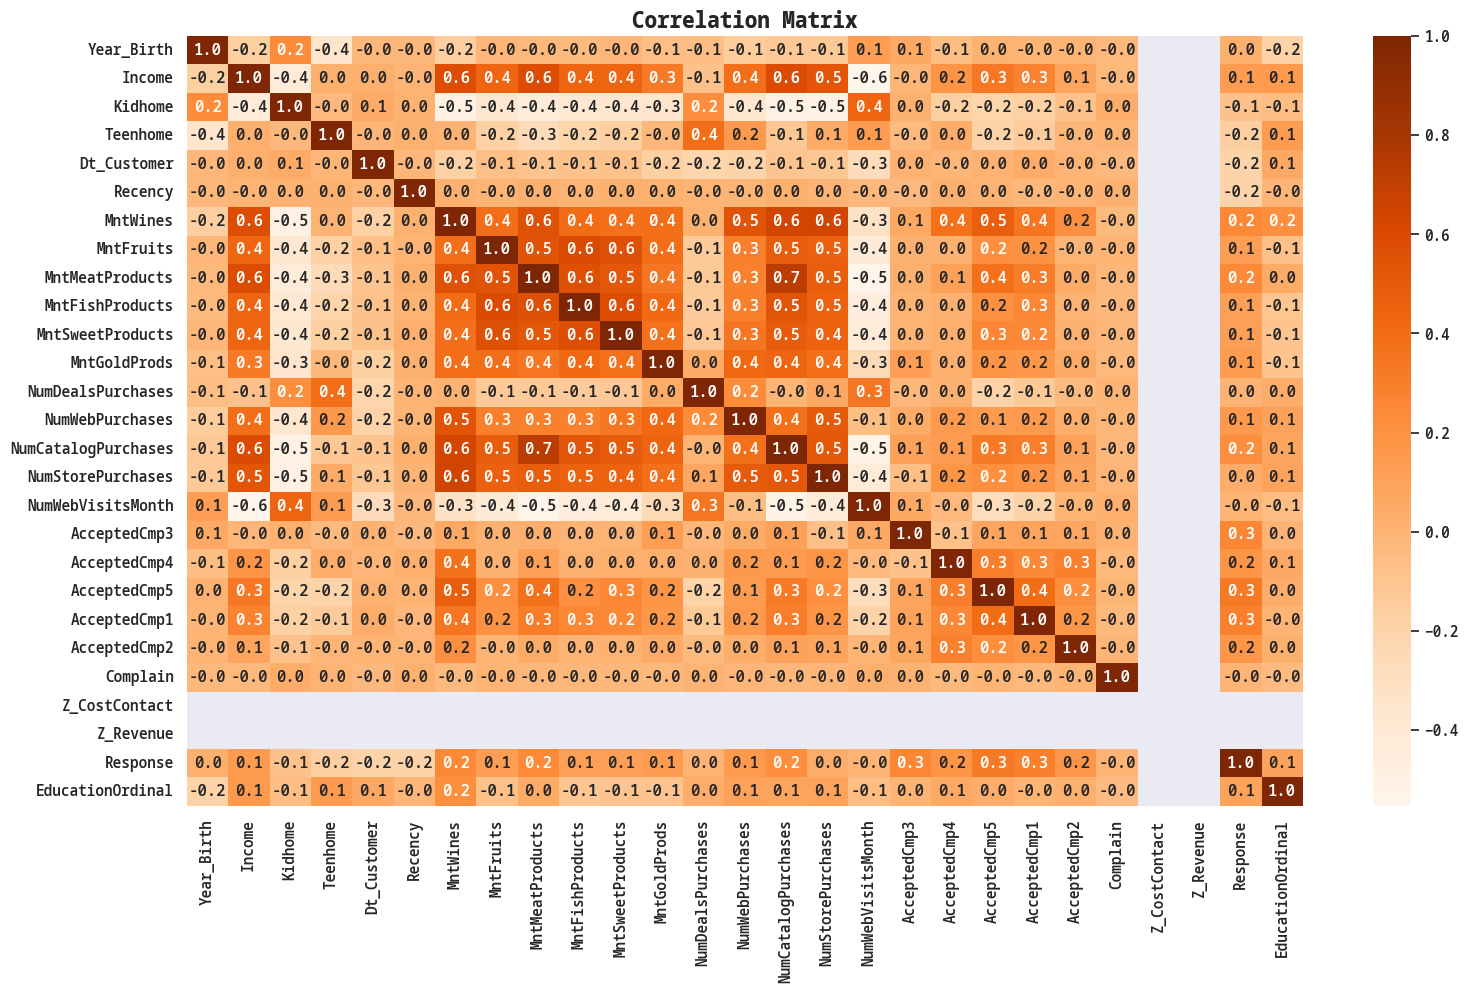

In [19]:
# heatmap
plt.figure(figsize=(18, 10))

sns.heatmap(
        df.corr(),
        annot=True,
        fmt='.1f',
        cmap='Oranges'
        )

plt.grid(False)

plt.title('Correlation Matrix', fontsize=16, fontweight=bold)
plt.show()

What about those columns with no correlation `Z_CostContact` and `Z_Revenue`.

In [20]:
df[['Z_CostContact', 'Z_Revenue']].head()

,Z_CostContact,Z_Revenue
0,3,11
1,3,11
2,3,11
3,3,11
4,3,11


In [21]:
df[['Z_CostContact', 'Z_Revenue']].nunique()

Z_CostContact    1
Z_Revenue        1
dtype: int64

Same value for all rows. We can drop them.

In [22]:
nunique_values = df.nunique()
nunique_values[nunique_values == 1]

Z_CostContact    1
Z_Revenue        1
dtype: int64

In [23]:
df.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

In [24]:
df.nunique().sort_values()

Complain                  2
AcceptedCmp2              2
AcceptedCmp1              2
AcceptedCmp5              2
AcceptedCmp4              2
AcceptedCmp3              2
Response                  2
Kidhome                   3
Teenhome                  3
EducationOrdinal          5
NumStorePurchases        14
NumCatalogPurchases      14
NumWebPurchases          15
NumDealsPurchases        15
NumWebVisitsMonth        16
Year_Birth               59
Recency                 100
MntFruits               158
MntSweetProducts        177
MntFishProducts         182
MntGoldProds            213
MntMeatProducts         558
Dt_Customer             663
MntWines                776
Income                 1974
dtype: int64

From the dataset documentation:
- `Kidhome`: Number of children in customer's household
- `Teenhome`: Number of teenagers in customer's household
- `AcceptedCmpX`: 1 if customer accepted the offer in the Xst campaign, 0 otherwise
- `Complain`: 1 if customer complained in the last 2 years, 0 otherwise
- `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

In [25]:
df['Kidhome'].value_counts()

Kidhome
0    1293
1     899
2      48
Name: count, dtype: int64

In [26]:
df['Teenhome'].value_counts()

Teenhome
0    1158
1    1030
2      52
Name: count, dtype: int64

Let's drop the categorical columns for now.

In [27]:
df.drop(columns=['AcceptedCmp1', 'AcceptedCmp2',
                 'AcceptedCmp3', 'AcceptedCmp4',
                 'AcceptedCmp5', 'Complain', 'Response'
                 ], inplace=True)

In [28]:
# non-numerical columns
df.select_dtypes(exclude='number').columns

Index(['Dt_Customer'], dtype='object')

Let's convert that to days since registration.

In [29]:
df['DaysSinceRegistration'] = (pd.Timestamp.now() - df['Dt_Customer']).dt.days
df['DaysSinceRegistration'].head()

0    4549
1    3999
2    4198
3    4025
4    4047
Name: DaysSinceRegistration, dtype: int64

In [30]:
df['DaysSinceRegistration'].describe()

count    2240.000000
mean     4239.582143
std       202.122512
min      3886.000000
25%      4066.750000
50%      4241.500000
75%      4415.000000
max      4585.000000
Name: DaysSinceRegistration, dtype: float64

In [31]:
df.drop(columns=['Dt_Customer'], inplace=True)

In [32]:
# Find columns with high correlation
corr = df.corr().abs()
np.fill_diagonal(corr.values, np.nan)
high_corr = (corr >= 0.6).any()
high_corr_cols = high_corr[high_corr].index
high_corr_cols

Index(['MntWines', 'MntMeatProducts', 'NumCatalogPurchases',
       'NumStorePurchases'],
      dtype='object')

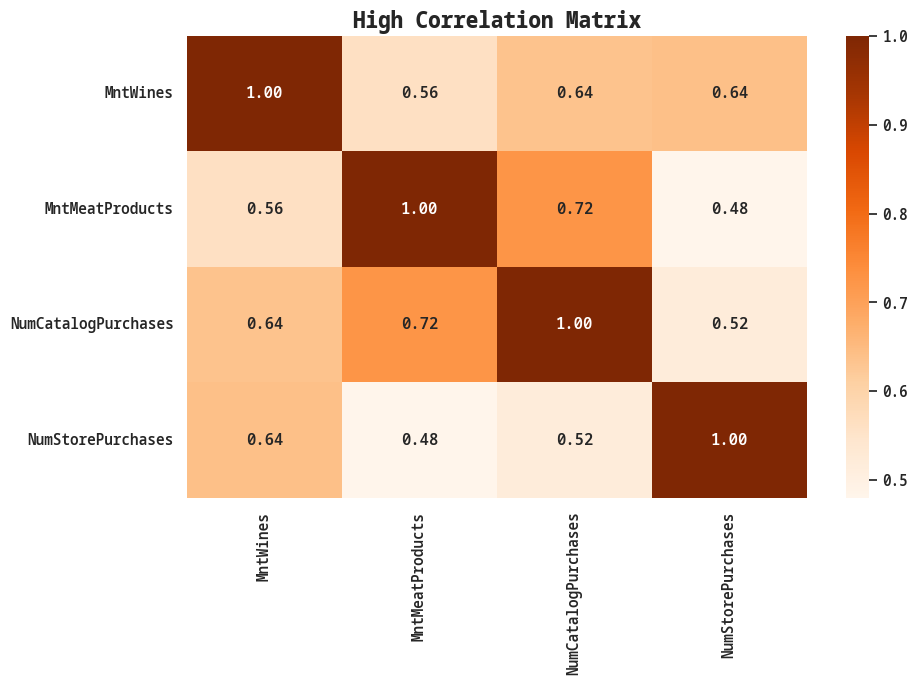

In [33]:
# Compute correlation matrix
corr_matrix = df.corr()

# Filter columns with at least one correlation >= 0.6 (excluding diagonal)
mask = (corr_matrix.abs() > 0.6) & (corr_matrix.abs() < 1.0)
filtered_columns = corr_matrix.columns[mask.any(axis=1)]

# Filter the correlation matrix
filtered_corr = corr_matrix.loc[filtered_columns, filtered_columns]

plt.figure(figsize=(10, 6))

sns.heatmap(
        filtered_corr,
        annot=True,
        fmt='.2f',
        cmap='Oranges'
        )

plt.grid(False)

plt.title('High Correlation Matrix', fontsize=16, fontweight=bold)
plt.show()

Some correlations here, nothing too high. We can keep all columns for now.

## Outliers

In [34]:
def iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [35]:
outliers_df = pd.DataFrame()

for column in df.select_dtypes(include='number'):
    lower_bound, upper_bound = iqr_bounds(df[column])

    percentage_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).mean()

    outliers_df = pd.concat([
        outliers_df,
        pd.DataFrame([[column, percentage_outliers]], columns=['Column', 'Percentage of Outliers'])
    ])

outliers_df.sort_values(by='Percentage of Outliers', ascending=False, inplace=True)
outliers_df['Outliers %'] = (outliers_df['Percentage of Outliers'] * 100).round(2).astype(str) + '%'
outliers_df[['Column', 'Outliers %']]

,Column,Outliers %
0,MntSweetProducts,11.07%
0,MntFruits,10.13%
0,MntFishProducts,9.96%
0,MntGoldProds,9.24%
0,MntMeatProducts,7.81%
0,NumDealsPurchases,3.84%
0,EducationOrdinal,2.41%
0,MntWines,1.56%
0,NumCatalogPurchases,1.03%
0,NumWebVisitsMonth,0.36%


## Preprocessing

In [36]:
median_income = df['Income'].median()
df['Income'].fillna(median_income, inplace=True)
median_income

51381.5

In [37]:
# Based on the above, created the following preprocessor
from preprocessing.preprocessor import Preprocessor

#### PCA

In [38]:
df.isna().sum()

Year_Birth               0
Income                   0
Kidhome                  0
Teenhome                 0
Recency                  0
MntWines                 0
MntFruits                0
MntMeatProducts          0
MntFishProducts          0
MntSweetProducts         0
MntGoldProds             0
NumDealsPurchases        0
NumWebPurchases          0
NumCatalogPurchases      0
NumStorePurchases        0
NumWebVisitsMonth        0
EducationOrdinal         0
DaysSinceRegistration    0
dtype: int64

In [39]:
# Number of features
len(df.columns)

18

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=0.95, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)

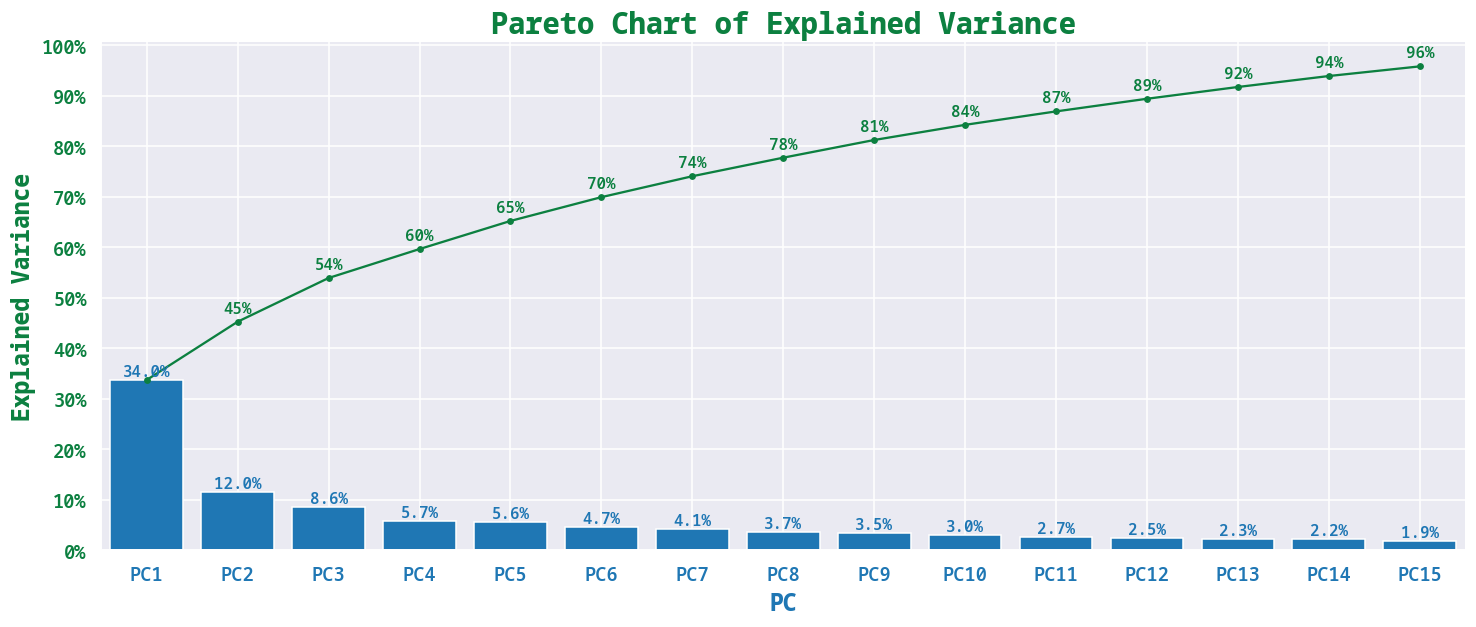

In [41]:
viz_df = pd.DataFrame(
        np.cumsum(pca.explained_variance_ratio_),
        columns=['Explained Variance']
        )

viz_df['PC'] = [f'PC{x}' for x in range(1, len(viz_df) + 1)]
viz_df['Explained Variance'] = (viz_df['Explained Variance'] * 100).round(2)

pareto(
        viz_df=viz_df,
        component_column='PC',
        cumulative_column='Explained Variance',
        bold_key=bold
        )

## Training
With optuna for hyperparameter tuning

In [42]:
preprocessing_pipeline = Pipeline([
    ('preprocessor', Preprocessor()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=random_state))
])

In [43]:
def run_study(objective, n_trials=50, direction='maximize'):
    started_at = datetime.now()

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    ended_at = datetime.now()

    duration_in_seconds = (ended_at - started_at).total_seconds()

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    print("Time taken:", humanize.naturaldelta(timedelta(seconds=duration_in_seconds)))

    return study

In [44]:
# Keeping 10 rows to simulate unseen data points being assigned to clusters
# using the persisted pipeline
seen_data = original_df[:-10].copy()
new_data = original_df[-10:].copy()

X = preprocessing_pipeline.fit_transform(seen_data)

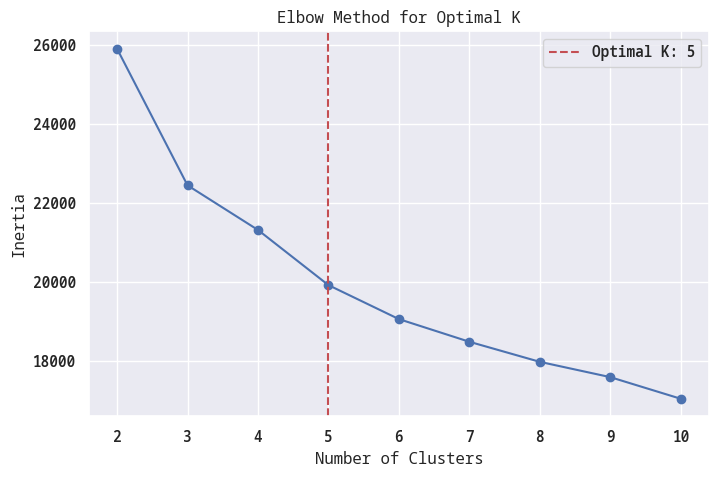

In [45]:
def find_optimal_clusters(X, max_k=10):
    inertia_values = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    # Find the elbow point
    elbow = KneeLocator(range(2, max_k + 1), inertia_values, curve="convex", direction="decreasing").elbow
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_k + 1), inertia_values, marker="o")
    plt.axvline(elbow, color="r", linestyle="--", label=f"Optimal K: {elbow}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.legend()
    plt.title("Elbow Method for Optimal K")
    plt.show()

    return elbow

optimal_k = find_optimal_clusters(X, max_k=10)

In [46]:
def objective(trial):
    n_clusters = trial.suggest_int(
            "n_clusters",
            max(2, optimal_k - 2),
            min(10, optimal_k + 2)
            )

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)

    num_clusters = len(set(labels))
    if num_clusters < 2:
        return float("-inf")

    return silhouette_score(X, labels)

study = run_study(objective, n_trials=100)

[I 2025-02-17 16:36:24,772] A new study created in memory with name: no-name-7050c0e0-a813-4f7b-a1fd-adc848c56a57


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-17 16:36:24,957] Trial 0 finished with value: 0.13320911025242493 and parameters: {'n_clusters': 7}. Best is trial 0 with value: 0.13320911025242493.
[I 2025-02-17 16:36:25,130] Trial 1 finished with value: 0.13320911025242493 and parameters: {'n_clusters': 7}. Best is trial 0 with value: 0.13320911025242493.
[I 2025-02-17 16:36:25,316] Trial 2 finished with value: 0.19612940175443416 and parameters: {'n_clusters': 4}. Best is trial 2 with value: 0.19612940175443416.
[I 2025-02-17 16:36:25,504] Trial 3 finished with value: 0.14088858360321804 and parameters: {'n_clusters': 5}. Best is trial 2 with value: 0.19612940175443416.
[I 2025-02-17 16:36:25,684] Trial 4 finished with value: 0.23085789941682514 and parameters: {'n_clusters': 3}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:25,871] Trial 5 finished with value: 0.19612940175443416 and parameters: {'n_clusters': 4}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:26,052] Trial 

[I 2025-02-17 16:36:34,740] Trial 52 finished with value: 0.23085789941682514 and parameters: {'n_clusters': 3}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:34,924] Trial 53 finished with value: 0.23085789941682514 and parameters: {'n_clusters': 3}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:35,148] Trial 54 finished with value: 0.23085789941682514 and parameters: {'n_clusters': 3}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:35,330] Trial 55 finished with value: 0.23085789941682514 and parameters: {'n_clusters': 3}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:35,530] Trial 56 finished with value: 0.19612940175443416 and parameters: {'n_clusters': 4}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:35,708] Trial 57 finished with value: 0.14340444068871336 and parameters: {'n_clusters': 6}. Best is trial 4 with value: 0.23085789941682514.
[I 2025-02-17 16:36:35,897] 

In [47]:
print('Best parameters:', study.best_params)
print('Best silhouette score:', study.best_value)

Best parameters: {'n_clusters': 3}
Best silhouette score: 0.23085789941682514


The best fit according to silhouette score appears for 3 clusters.

In [48]:
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('kmeans', KMeans(n_clusters=study.best_params['n_clusters'], random_state=random_state))
])

In [49]:
pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  <preprocessing.preprocessor.Preprocessor object at 0x7fa64cf073a0>),
                                 ('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=0.95, random_state=42))])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [50]:
pipeline.fit(seen_data)
seen_data['Cluster'] = pipeline.predict(seen_data)
seen_data['Cluster'].value_counts()

Cluster
1    1013
2     636
0     581
Name: count, dtype: int64

## Store the fitted pipeline
For future assignments of clusters

In [51]:
model_dir = Path('models')
# Creates folder if it doesn’t exist
model_dir.mkdir(exist_ok=True)

In [52]:
model_filename = model_dir / 'customer_clustering_pipeline.joblib'
model_filename

PosixPath('models/customer_clustering_pipeline.joblib')

In [53]:
joblib.dump(pipeline, model_filename)

['models/customer_clustering_pipeline.joblib']

## Use the persisted pipeline
To assign clusters to new data points

In [54]:
pipeline = joblib.load(model_filename)

In [55]:
new_data['Cluster'] = pipeline.predict(new_data.copy())
new_data['Cluster'].value_counts()

Cluster
1    5
0    3
2    2
Name: count, dtype: int64

## Interpretation
Using decision trees to interpret the clusters

In [56]:
preprocessed_data = Pipeline([
    ('preprocessor', Preprocessor()),
    ('scaler', StandardScaler())
]).fit_transform(seen_data.drop(columns=['Cluster']))

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_data,
    seen_data['Cluster'],
    test_size=0.2,
    random_state=random_state
)

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       115
           1       0.98      0.95      0.97       197
           2       0.97      0.96      0.97       134

    accuracy                           0.95       446
   macro avg       0.95      0.95      0.95       446
weighted avg       0.95      0.95      0.95       446



In [57]:
seen_data['Cluster'].value_counts()

Cluster
1    1013
2     636
0     581
Name: count, dtype: int64

Considering the above f1-score and the fact that all clusters are represented in the dataset, we can conclude that the random forest does a great job at identifying clusters based on the features provided.
<br />
Let's look at the feature importance.

In [58]:
feature_importance = rf.feature_importances_
features = Preprocessor().fit_transform(seen_data.drop(columns=['Cluster'])).columns

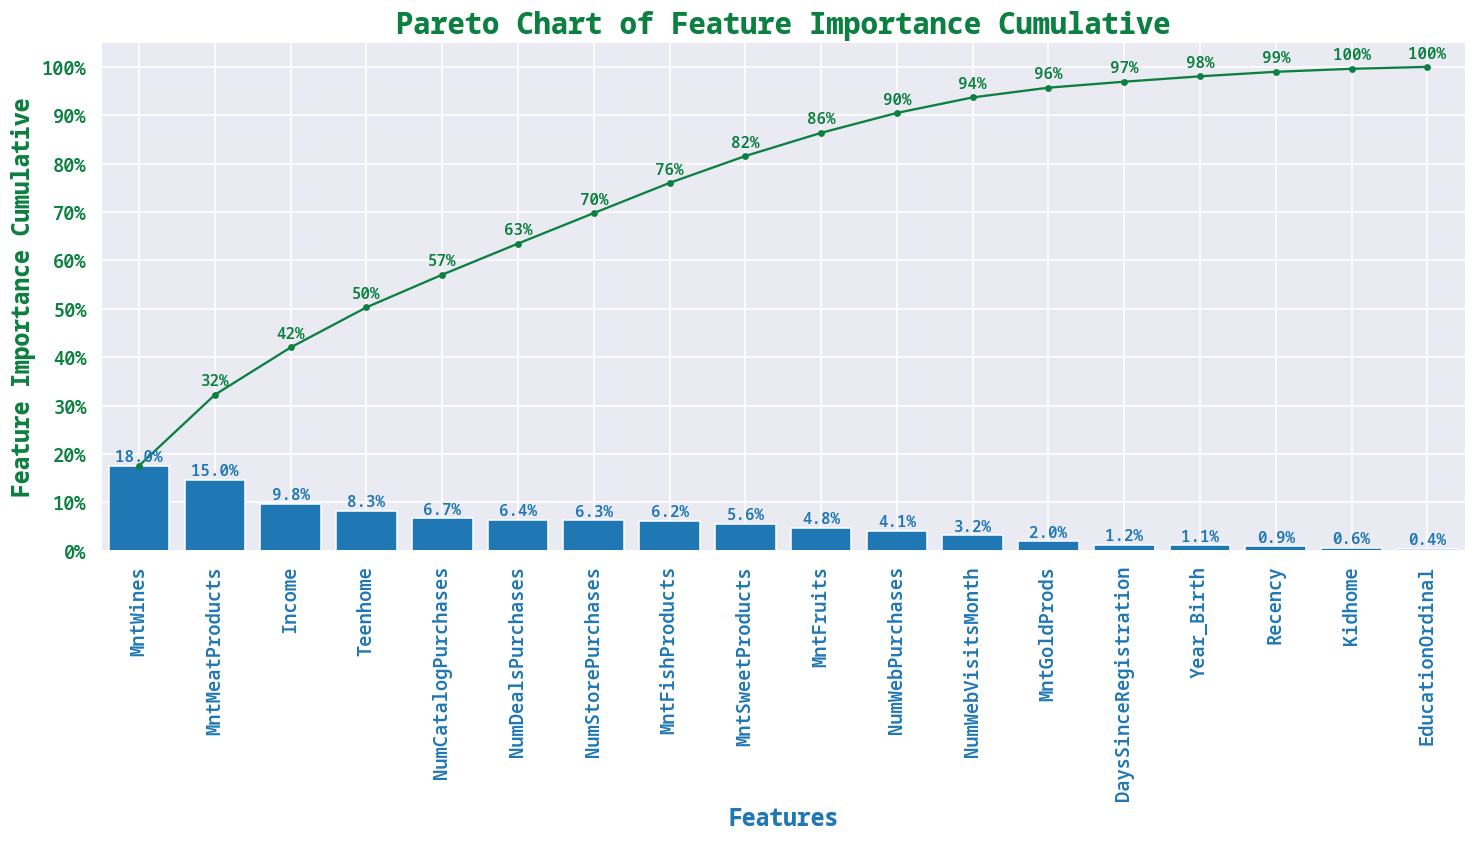

In [59]:
viz_df = pd.DataFrame({
          'Features': features,
          'Feature Importance': feature_importance / feature_importance.sum()
        }).sort_values(by='Feature Importance', ascending=False)

viz_df['Feature Importance Cumulative'] = viz_df['Feature Importance'].cumsum() * 100
viz_df.drop(columns=['Feature Importance'], inplace=True)

pareto(
        viz_df=viz_df,
        component_column='Features',
        cumulative_column='Feature Importance Cumulative',
        bold_key=bold
        )

In [60]:
viz_df

,Features,Feature Importance Cumulative
5,MntWines,17.616814
7,MntMeatProducts,32.261553
1,Income,42.039512
3,Teenhome,50.322506
13,NumCatalogPurchases,57.066500
11,NumDealsPurchases,63.494511
14,NumStorePurchases,69.789720
8,MntFishProducts,76.030519
9,MntSweetProducts,81.583913
6,MntFruits,86.370472


In [61]:
viz_df['non_cumulative'] = viz_df['Feature Importance Cumulative'] - viz_df['Feature Importance Cumulative'].shift(1).fillna(0)
important_features = viz_df[viz_df['non_cumulative'] > 5]['Features'].tolist()
important_features

['MntWines',
 'MntMeatProducts',
 'Income',
 'Teenhome',
 'NumCatalogPurchases',
 'NumDealsPurchases',
 'NumStorePurchases',
 'MntFishProducts',
 'MntSweetProducts']

The features that stand out accounting for a little over 80% of the feature importance are:
1. 'MntWines'
2. 'MntMeatProducts'
3. 'Income'
4. 'Teenhome'
5. 'NumCatalogPurchases'
6. 'NumDealsPurchases'
7. 'NumStorePurchases'
8. 'MntFishProducts'
9. 'MntSweetProducts'

How different is the amount spent on meat for each cluster?

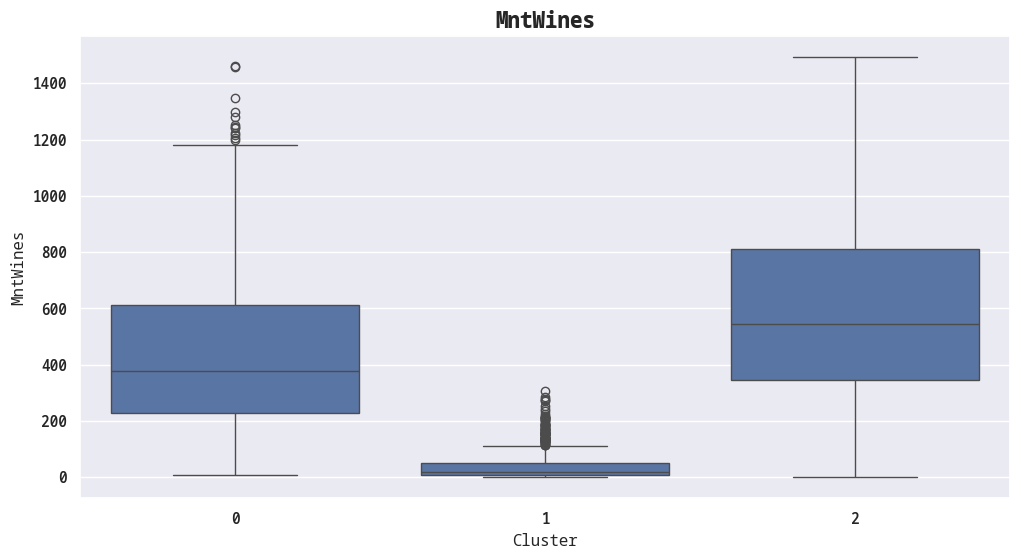

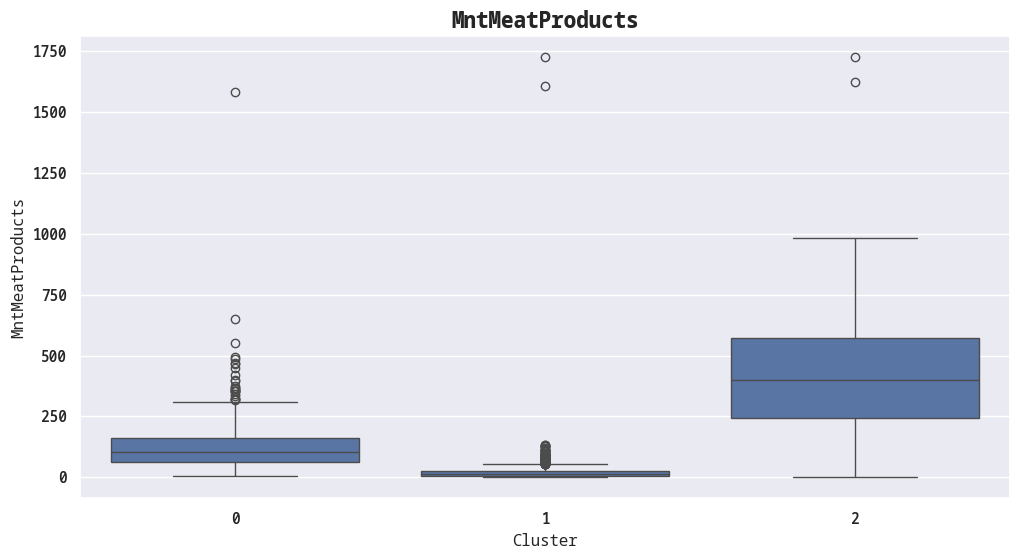

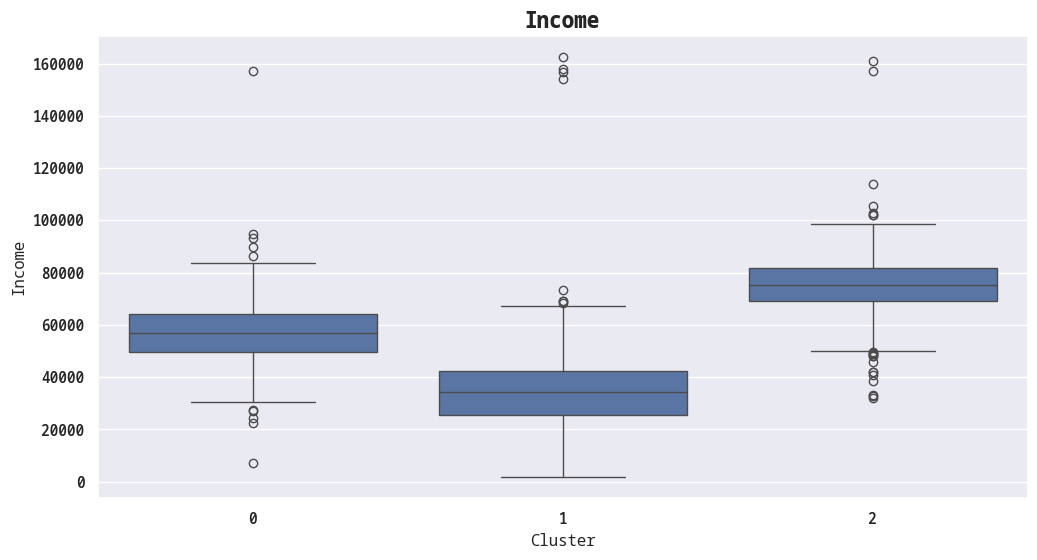

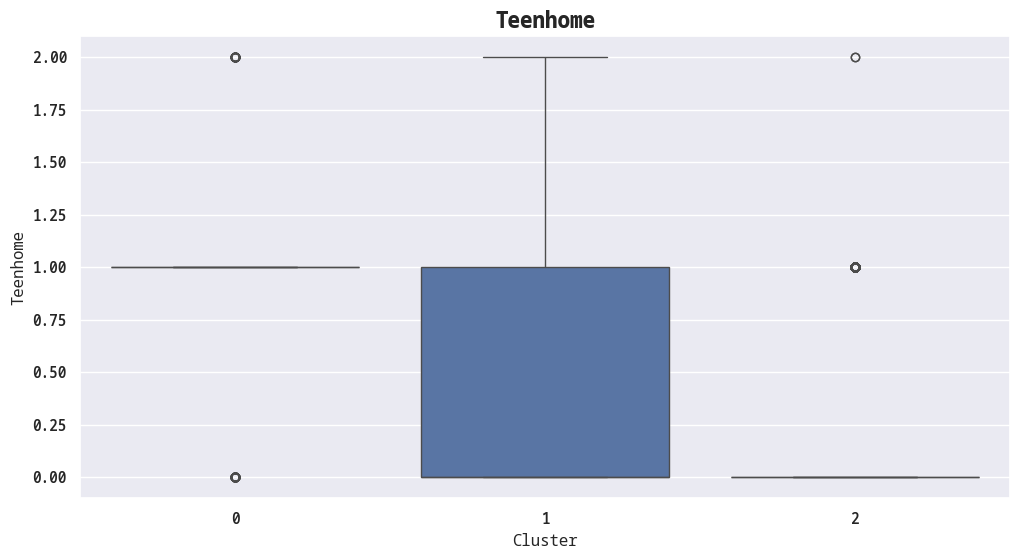

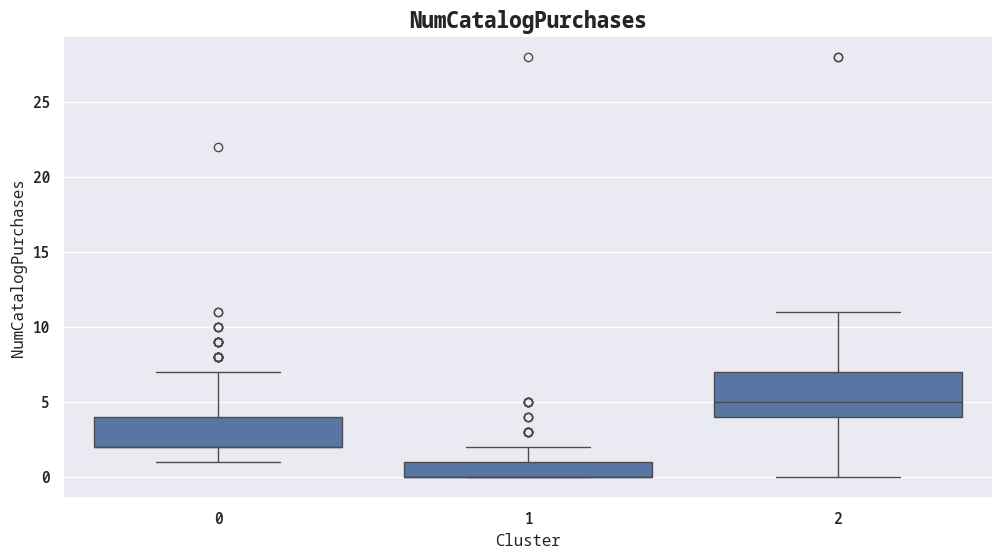

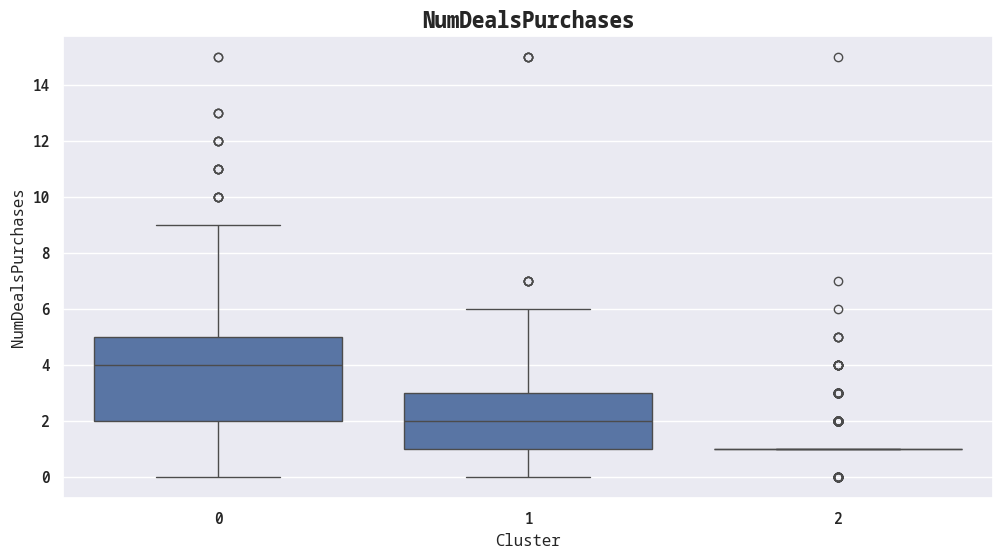

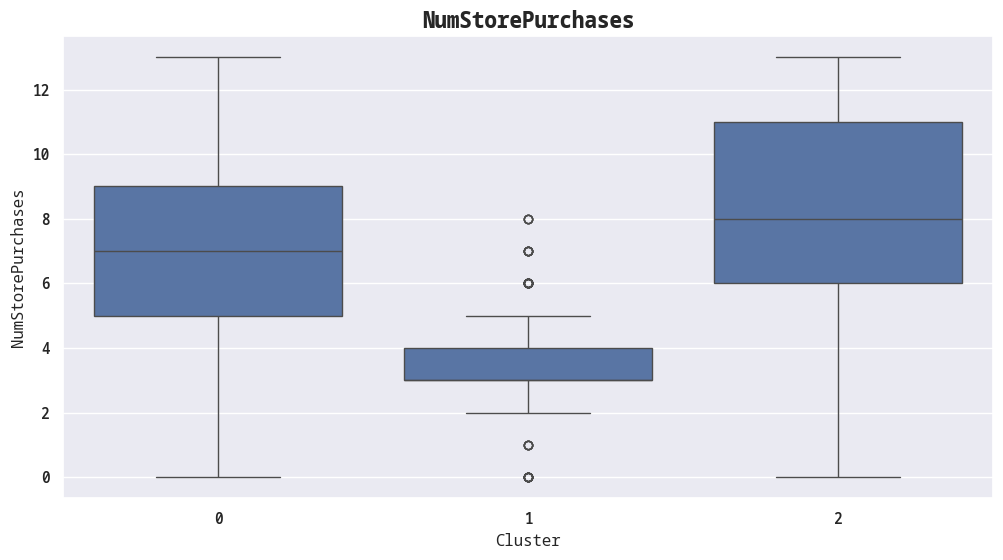

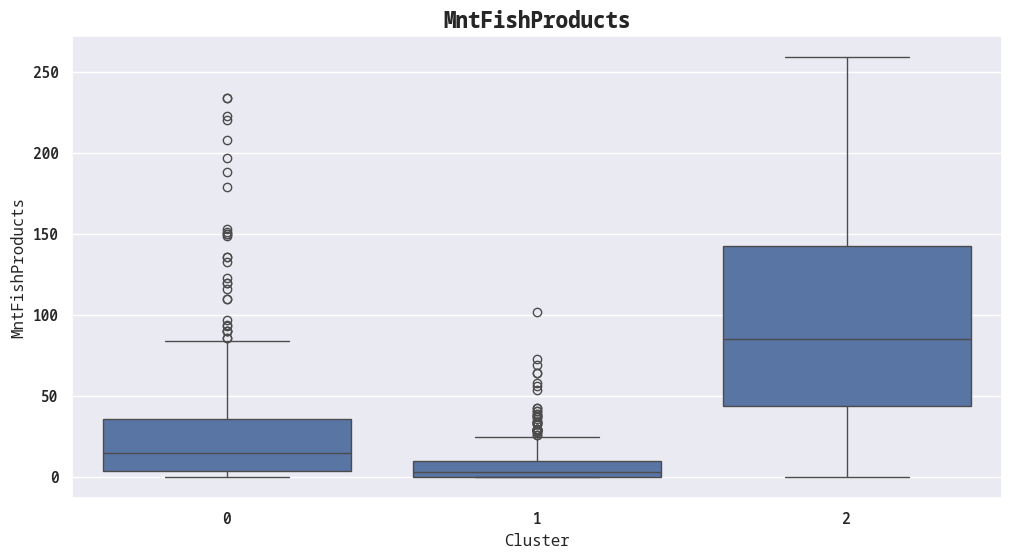

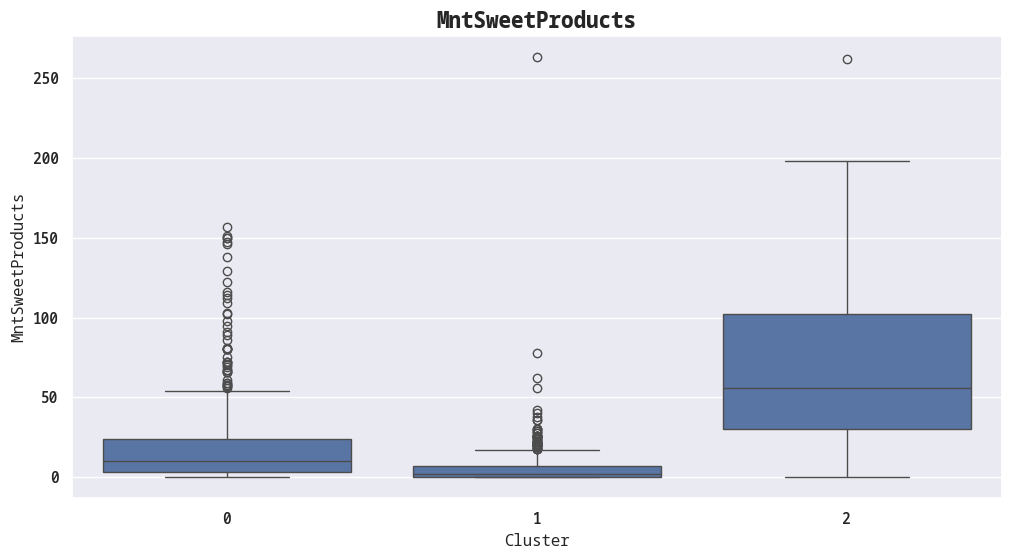

In [62]:
for feature in important_features:
    plt.figure(figsize=(12, 6))

    sns.boxplot(
            x='Cluster',
            y=feature,
            data=seen_data
            )

    plt.title(feature,
              fontsize=16,
              fontweight=bold
              )
    plt.show()

The number of teenagers in the household(Teenhome) appear to be present almost exclusively in cluster 2

In [63]:
seen_data.groupby(['Cluster', 'Teenhome']).size()

Cluster  Teenhome
0        0            68
         1           476
         2            37
1        0           581
         1           419
         2            13
2        0           503
         1           131
         2             2
dtype: int64

## Hypothesis Testing

For each of the important features, we will test the following hypothesis:
<br />
$H_0$: The means of the clusters are **not** different.
<br />
$H_1$: The means of the clusters **are** different.

In [64]:
ALPHA = 0.05

In [65]:
def compare_clusters(df, column):
    cluster_0 = df[df['Cluster'] == 0][column]
    cluster_1 = df[df['Cluster'] == 1][column]
    cluster_2 = df[df['Cluster'] == 2][column]

    f_stat, p_value = f_oneway(cluster_0, cluster_1, cluster_2)

    if p_value < ALPHA:
        print('Reject the null hypothesis, the difference is statistically significant.')
        print()

        # Prepare data for Tukey's HSD test
        tukey_data = df[[column, 'Cluster']]
        tukey_data = tukey_data.dropna()
        tukey_data['Cluster'] = tukey_data['Cluster'].astype(str)  # Tukey test requires categorical groups

        # Perform Tukey's HSD test
        tukey_results = pairwise_tukeyhsd(endog=tukey_data[column],
                                          groups=tukey_data['Cluster'],
                                          alpha=ALPHA)
        print(tukey_results)
    else:
        print('Fail to reject the null hypothesis, the difference is not statistically significant.')

In [66]:
compare_clusters(seen_data, 'MntWines')

Reject the null hypothesis, the difference is statistically significant.

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     0      1 -410.4717   0.0 -438.3258 -382.6176   True
     0      2  143.2143   0.0  112.4982  173.9304   True
     1      2   553.686   0.0  526.6081  580.7638   True
--------------------------------------------------------


In [67]:
seen_data.groupby('Cluster')['MntWines'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,449.376936,38.905232,592.591195
std,287.164030,48.521509,321.844090
min,7.000000,0.000000,1.000000
25%,229.000000,8.000000,345.000000
50%,378.000000,20.000000,543.500000
75%,614.000000,51.000000,813.000000
max,1462.000000,308.000000,1493.000000


`Cluster 2` has the highest spending on wines with `Cluster 0` following closely behind. `Cluster 1` has a very low spending on wines compared to the other clusters.

In [68]:
compare_clusters(seen_data, 'MntMeatProducts')

Reject the null hypothesis, the difference is statistically significant.

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2  meandiff p-adj   lower    upper   reject
-------------------------------------------------------
     0      1 -103.2953   0.0 -121.3511 -85.2394   True
     0      2   301.454   0.0  281.5429 321.3651   True
     1      2  404.7493   0.0  387.1965  422.302   True
-------------------------------------------------------


In [69]:
seen_data.groupby('Cluster')['MntMeatProducts'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,128.240964,24.945706,429.694969
std,108.387812,76.469297,238.124552
min,6.000000,0.000000,3.000000
25%,64.000000,7.000000,242.750000
50%,102.000000,14.000000,400.000000
75%,162.000000,26.000000,570.500000
max,1582.000000,1725.000000,1725.000000


`Cluster 2` spends the most on meat products. `Cluster 0` has a moderate spending on meat products while `Cluster 1` has a very low spending compared to the other clusters.

In [70]:
compare_clusters(seen_data, 'Income')

Fail to reject the null hypothesis, the difference is not statistically significant.


Income does not appear to differ significantly across clusters

In [71]:
compare_clusters(seen_data, 'Teenhome')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.5074   0.0 -0.5646 -0.4501   True
     0      2  -0.7344   0.0 -0.7975 -0.6713   True
     1      2   -0.227   0.0 -0.2826 -0.1714   True
---------------------------------------------------


In [72]:
seen_data.groupby(['Cluster', 'Teenhome']).size()

Cluster  Teenhome
0        0            68
         1           476
         2            37
1        0           581
         1           419
         2            13
2        0           503
         1           131
         2             2
dtype: int64

`Cluster 0` appear more like to have at least one teenager in the household, `Cluster 2` appears more like to have none, and `Cluster 1` appears balanced between having and not having teenagers in the house.
<br />
In a future iteration, we could create a `Parent` categorical variable and try a clustering that allows for categorical variables.

In [73]:
compare_clusters(seen_data, 'NumCatalogPurchases')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   -2.401   0.0 -2.6379 -2.164   True
     0      2   2.8186   0.0  2.5574 3.0799   True
     1      2   5.2196   0.0  4.9893 5.4499   True
--------------------------------------------------


In [74]:
seen_data.groupby('Cluster')['NumCatalogPurchases'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,2.951807,0.550839,5.770440
std,2.073915,1.132799,2.691042
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000
50%,2.000000,0.000000,5.000000
75%,4.000000,1.000000,7.000000
max,22.000000,28.000000,28.000000


`Cluster 2` has the greatest number of catalog purchases, `Cluster 0` has a moderate number of catalog purchases and `Cluster 1` has a low or negligible number of catalog purchases.

In [75]:
compare_clusters(seen_data, 'NumDealsPurchases')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -2.0717   0.0 -2.2693 -1.8741   True
     0      2  -2.7286   0.0 -2.9465 -2.5107   True
     1      2  -0.6569   0.0  -0.849 -0.4648   True
---------------------------------------------------


In [76]:
seen_data.groupby('Cluster')['NumDealsPurchases'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,4.043029,1.971372,1.314465
std,2.366404,1.395989,0.985810
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,1.000000
max,15.000000,15.000000,15.000000


Customers in `Cluster 0` appear more likely to purchase a deal when compared with customers from `Cluster 1` and `Cluster 2` 

In [77]:
compare_clusters(seen_data, 'NumStorePurchases')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -4.2866   0.0 -4.5488 -4.0244   True
     0      2   1.0405   0.0  0.7514  1.3296   True
     1      2   5.3271   0.0  5.0723   5.582   True
---------------------------------------------------


In [78]:
seen_data.groupby('Cluster')['NumStorePurchases'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,7.440620,3.153998,8.481132
std,2.627836,1.055747,2.845849
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,6.000000
50%,7.000000,3.000000,8.000000
75%,9.000000,4.000000,11.000000
max,13.000000,8.000000,13.000000


`Cluster 1` appears to make less store purchases than `Cluster 0` and `Cluster
2`. `Cluster 2` appears to make slightly more store purchases than `Cluster
1`, but the difference is small.

What is the distribution of web purchases across clusters? Is perhaps `Cluster
1` more likely to purchase online?

In [79]:
compare_clusters(seen_data, 'NumWebPurchases')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -4.1536   0.0 -4.4057 -3.9015   True
     0      2  -0.9372   0.0 -1.2152 -0.6592   True
     1      2   3.2164   0.0  2.9714  3.4614   True
---------------------------------------------------


Nope, they simply appear to purchase less.

In [80]:
compare_clusters(seen_data, 'MntFishProducts')

Reject the null hypothesis, the difference is statistically significant.

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1 -19.8989   0.0 -24.6751 -15.1227   True
     0      2  70.1475   0.0  64.8805  75.4144   True
     1      2  90.0464   0.0  85.4033  94.6895   True
-----------------------------------------------------


In [81]:
seen_data.groupby('Cluster')['MntFishProducts'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,26.640275,6.741362,96.787736
std,35.476797,9.508901,63.850593
min,0.000000,0.000000,0.000000
25%,4.000000,0.000000,44.000000
50%,15.000000,3.000000,85.000000
75%,36.000000,10.000000,142.750000
max,234.000000,102.000000,259.000000


`Cluster 2` spends the most on fish products, `Cluster 0` a moderate to low amount, while `Cluster 1` has a low spending.

In [82]:
compare_clusters(seen_data, 'MntSweetProducts')

Reject the null hypothesis, the difference is statistically significant.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     0      1 -13.9368   0.0 -17.7166 -10.157   True
     0      2  50.3778   0.0  46.2096  54.546   True
     1      2  64.3147   0.0  60.6402 67.9891   True
----------------------------------------------------


In [83]:
seen_data.groupby('Cluster')['MntSweetProducts'].describe().T

Cluster,0,1,2
count,581.000000,1013.000000,636.000000
mean,19.067126,5.130306,69.444969
std,26.024934,10.765962,50.598513
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,30.000000
50%,10.000000,2.000000,56.000000
75%,24.000000,7.000000,102.000000
max,157.000000,263.000000,262.000000


`Cluster 2` has the highest spending on sweet products, `Cluster 0` has a moderate spending and `Cluster 1` has a low spending.

## Profiling

Cluster 0: Average spenders
- Purchaser of wines
- Moderate spending on meat and sweet products
- Moderate number of catalog purchases
- More likely to purchase a deal
- Moderate to low spending on fish products

Cluster 1: Low spenders
- Low spending on wines, meat, fish and sweet products
- Low number of purchases in general, be it catalog, store or web purchases.
- Less likely to purchase a deal

Cluster 2: High spenders
- Purchaser of wines
- High spender on meats, fish and sweet products
- High number of catalog purchases
- Less likely to purchase a deal

<br />

Note: Income, although it was used in the clustering and might appear
different across clusters, was not found to be statistically significant
across clusters.

## Conclusion

Having split the customer base into the above clusters, we can better tailor
marketing campaigns to each cluster. For instance, we could offer discounts
and value-for-money packs to `Average spenders`, or promote premium products
to `High spenders`.

Hope this analysis was insightful. Thank you for reading!